### Required libraries

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime as dt
# import datetime as dt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score 
# from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy import stats
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import plotDecisionTree, classificationSummary, regressionSummary
import statsmodels.formula.api as sm
from haversine import haversine, Unit


import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib import style
%matplotlib inline
# import matplotlib.cm as cm
# from matplotlib import *

import warnings
warnings.filterwarnings('ignore')

no display found. Using non-interactive Agg backend


# 1. Load Data

In [2]:
home_sales = pd.read_csv('training_dataset.csv')

In [3]:
# Use the head method to display the first 5 rows
home_sales.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3787000140,20140901T000000,450000,3,2.25,1780,9969,1.0,0,0,...,8,1450,330,1985,0,98034,47.7286,-122.168,1950,7974
1,1934800078,20140930T000000,430000,2,2.25,1040,1516,2.0,0,0,...,8,1040,0,2008,0,98122,47.6037,-122.307,1560,1920
2,7331900290,20140731T000000,230000,4,1.50,1520,8800,1.0,0,0,...,7,1520,0,1960,0,98002,47.3136,-122.208,1370,8800


In [4]:
# Check the shape of the DataFrame (rows, columns)
home_sales.shape

(17614, 21)

In [5]:
home_sales.info()
# We notice that there is no NaN values in the Data set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17614 entries, 0 to 17613
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17614 non-null  int64  
 1   date           17614 non-null  object 
 2   price          17614 non-null  int64  
 3   bedrooms       17614 non-null  int64  
 4   bathrooms      17614 non-null  float64
 5   sqft_living    17614 non-null  int64  
 6   sqft_lot       17614 non-null  int64  
 7   floors         17614 non-null  float64
 8   waterfront     17614 non-null  int64  
 9   view           17614 non-null  int64  
 10  condition      17614 non-null  int64  
 11  grade          17614 non-null  int64  
 12  sqft_above     17614 non-null  int64  
 13  sqft_basement  17614 non-null  int64  
 14  yr_built       17614 non-null  int64  
 15  yr_renovated   17614 non-null  int64  
 16  zipcode        17614 non-null  int64  
 17  lat            17614 non-null  float64
 18  long  

In [6]:
# count for the unique values in each variable, which is also useful to understand their distribution
for column in home_sales.columns:
    uniques = home_sales[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

id                   17494	 [3787000140 1934800078 7331900290 3438500798 2697400020]
date                   370	 ['20140901T000000' '20140930T000000' '20140731T000000' '20140715T000000'
 '20141031T000000']
price                 3595	 [450000 430000 230000 275000 400000]
bedrooms                12	 [3 2 4 1 5]
bathrooms               30	 [2.25 1.5  2.   1.   2.5 ]
sqft_living            953	 [1780 1040 1520 1060 1350]
sqft_lot              8515	 [9969 1516 8800 6954 7216]
floors                   6	 [1.  2.  1.5 2.5 3. ]
waterfront               2	 [0 1]
view                     5	 [0 2 1 4 3]
condition                5	 [3 4 5 2 1]
grade                   12	 [ 8  7  6 10  5]
sqft_above             870	 [1450 1040 1520 1060 1350]
sqft_basement          286	 [330   0 460 650 120]
yr_built               116	 [1985 2008 1960 1983 1964]
yr_renovated            68	 [   0 1984 2008 2014 2002]
zipcode                 70	 [98034 98122 98002 98106 98177]
lat                   4853	 [47.7286 47.

In [7]:
# Use the describe method to generates descriptive statistics that summarize the central 
# tendency, dispersion and shape of the dataset’s distribution, excluding NaN values
home_sales.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.761400e+04,1.761400e+04,17614.000000,17614.000000,17614.000000,1.761400e+04,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000
mean,4.569068e+09,5.408514e+05,3.372431,2.113475,2080.915692,1.513310e+04,1.495856,0.007097,0.233848,3.409844,7.660100,1789.456398,291.459294,1970.917566,80.774384,98078.043204,47.560487,-122.214127,1985.633303,12680.009424
std,2.869570e+09,3.685506e+05,0.935641,0.773550,923.863759,4.194362e+04,0.540092,0.083944,0.765230,0.649949,1.179174,831.418845,443.419741,29.425821,393.288442,53.473239,0.138408,0.140161,685.581487,26713.761385
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,2.122052e+09,3.225000e+05,3.000000,1.500000,1420.000000,5.053250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471600,-122.328000,1480.000000,5100.000000
50%,3.904985e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.607000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.572700,-122.230000,1840.000000,7600.000000
75%,7.300200e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.065000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10057.250000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


# 2. Feature Engineering

### 2.1 Feature Distribution

Plot the density distribution for all variables in order to decide the feature parsing method

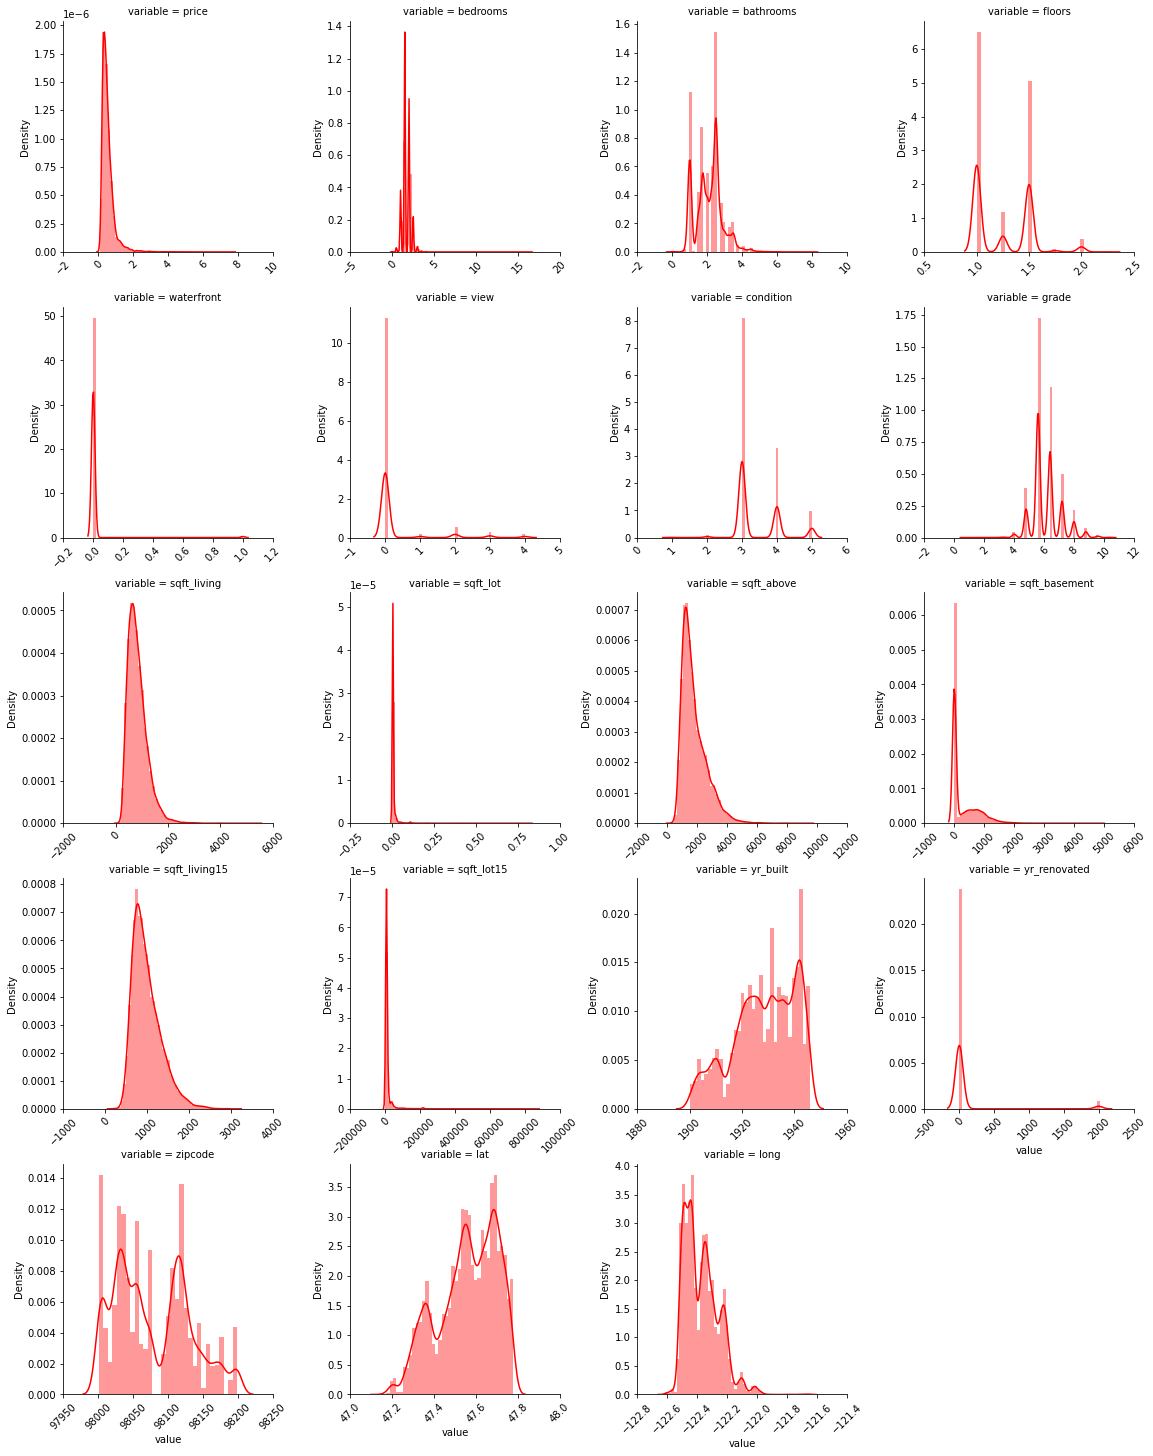

In [8]:
features = ['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
            'sqft_living','sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
            'yr_built','yr_renovated', 'zipcode', 'lat', 'long', ]
features_frame = pd.melt(home_sales, value_vars = features)
dis_plot = sns.FacetGrid(features_frame, col = 'variable', col_wrap = 4, sharex = False, sharey = False, height=4)
dis_plot = dis_plot.map(sns.distplot, 'value', color='r')
dis_plot.set_xticklabels(rotation = 45)
plt.show()

### 2.2    'price'

From the distribution plots above we notice that 'price' has a long tail rhs even after we have truncated some extreme values.

We can use log scale tranfer, so that the distribution of price variable will close to a normal distribution.

In [9]:
#removing outliers from data:
print(home_sales['price'].mean(), home_sales['price'].std(), 
      home_sales['price'].mean() - 3 * home_sales['price'].std(), 
      home_sales['price'].mean() + 3 * home_sales['price'].std())
home_sales = home_sales[(home_sales['price'] > (home_sales['price'].mean() - 3 * home_sales['price'].std()))
                       & (home_sales['price'] < (home_sales['price'].mean() + 3 * home_sales['price'].std()))] 

540851.3554558874 368550.61193291494 -564800.4803428574 1646503.191254632


In [10]:
home_sales['price_log'] = np.log(home_sales['price'])

first_col = home_sales.pop('price_log')
home_sales.insert(0, 'price_log', first_col)    #move the log_price variable to the front

### 2.3     'Sale_date'

Transfer 'date' into datetime and drop the 'id' variable.

Generate varible of sale_year, sale_month and sale_week to capture the seasonality of house price.

In [11]:
# Transfer 'date' into datetime and drop the 'id' variable.
home_sales['sale_date'] = [x[:8] for x in home_sales.date]
home_sales.sale_date = home_sales.sale_date.apply(lambda x: dt.strptime(x, '%Y%m%d'))
home_sales.drop(columns = 'date', inplace = True)
home_sales.drop(columns = 'id', inplace = True)

home_sales['sale_year'] = home_sales['sale_date'].dt.year
home_sales['sale_month'] = home_sales['sale_date'].dt.month
home_sales['sale_week'] = home_sales['sale_date'].dt.week

### 2.4    'yr_built' & 'yr_renovated'

We found that both 'yr_built' and 'yr_renovated' can represent the condition of the house

Meanwhile, we think it's better to transfer year into age, and if the house has never been renovated, then it has a same age with its original age.

In [12]:
home_sales['age'] = pd.DatetimeIndex(home_sales['sale_date']).year - home_sales['yr_built']
home_sales['age_renew'] = np.where(home_sales.yr_renovated == 0,
                home_sales.age, 
                pd.DatetimeIndex(home_sales['sale_date']).year - home_sales.yr_renovated)

### 2.5    variables with 'sqft'

From the distribution plots above we notice that most of the variables with 'sqft' have a long tail rhs, which leads to the variables's distribution are highly affected by its absolyte value.
We use MinMax to reduce this effect:

In [13]:
scaler = preprocessing.MinMaxScaler()
sqft_names = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
                            'sqft_living15', 'sqft_lot15']
home_sales[sqft_names] = scaler.fit_transform(home_sales[sqft_names])

### 2.6    'lat' & 'long'

'lat' & 'long' represents the absolute location of the house. While a more direct variable related to house price should be the distance of the house to downtown.
For King County, both Seattle and Bellevue are city center. Then we generate two extra varibales to denote these distance.

In [14]:
home_sales['lat_long'] = tuple(zip(home_sales.lat,home_sales.long))
home_sales['lat_long'].head()

0    (47.7286, -122.168)
1    (47.6037, -122.307)
2    (47.3136, -122.208)
3    (47.5498, -122.355)
4    (47.7616, -122.365)
Name: lat_long, dtype: object

In [15]:
seattle_latlong = [47.608013,-122.335167]
seattle_list = []
for i in home_sales['lat_long']:
    seattle_list.append(haversine((seattle_latlong),(i),unit = 'mi'))
print(seattle_list [:5])
print(len(seattle_list))

[11.398125908934658, 1.3455632835958153, 21.191636074427773, 4.12699245759895, 10.702195059127325]
17285


In [16]:
home_sales['distance_from_seattle'] = seattle_list

In [17]:
bellevue = tuple([47.610378, -122.200676])
bell_distances = []
for i in home_sales['lat_long']:
    bell_distances.append(haversine((bellevue),(i),unit = 'mi'))
bell_distances[:5]
print(len(bell_distances))

17285


In [18]:
home_sales['distance_from_bellevue'] = bell_distances
home_sales.tail(3)

,price_log,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_lot15,sale_date,sale_year,sale_month,sale_week,age,age_renew,lat_long,distance_from_seattle,distance_from_bellevue
17611,12.608199,299000,3,1.00,0.093185,0.004592,1.0,0,0,3,...,0.008548,2014-08-13,2014,8,33,59,59,"(47.7763, -122.305)",11.711862,12.448515
17612,12.880292,392500,3,1.75,0.173853,0.005091,1.0,0,0,4,...,0.011186,2014-11-19,2014,11,47,57,57,"(47.7762, -122.337)",11.620928,13.094383
17613,12.538967,279000,6,1.75,0.271210,0.006457,2.0,0,0,4,...,0.008381,2015-04-16,2015,4,16,60,60,"(47.42, -122.323)",13.002864,14.339060


In [19]:
home_sales['distance_from_downtown']=home_sales[['distance_from_bellevue', 'distance_from_seattle']].min(axis=1)
home_sales.head(3)

,price_log,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sale_date,sale_year,sale_month,sale_week,age,age_renew,lat_long,distance_from_seattle,distance_from_bellevue,distance_from_downtown
0,13.017003,450000,3,2.25,0.207232,0.005724,1.0,0,0,3,...,2014-09-01,2014,9,36,29,29,"(47.7286, -122.168)",11.398126,8.308646,8.308646
1,12.971540,430000,2,2.25,0.104312,0.000603,2.0,0,0,3,...,2014-09-30,2014,9,40,6,6,"(47.6037, -122.307)",1.345563,4.974398,1.345563
2,12.345835,230000,4,1.50,0.171071,0.005016,1.0,0,0,4,...,2014-07-31,2014,7,31,54,54,"(47.3136, -122.208)",21.191636,20.508261,20.508261


### 2.7 Drop redundant variables

In [20]:
home_sales.columns

Index(['price_log', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sale_date', 'sale_year',
       'sale_month', 'sale_week', 'age', 'age_renew', 'lat_long',
       'distance_from_seattle', 'distance_from_bellevue',
       'distance_from_downtown'],
      dtype='object')

In [21]:
home_sales.drop(columns=['price', 'sale_date',  'yr_built', 'yr_renovated', 'lat', 'long', 
                         'distance_from_bellevue','distance_from_seattle','lat_long'], inplace = True)
home_sales.columns

Index(['price_log', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15', 'sale_year',
       'sale_month', 'sale_week', 'age', 'age_renew',
       'distance_from_downtown'],
      dtype='object')

# 3. Data Visualization 

### 3.1 variables distribution after feature engineering

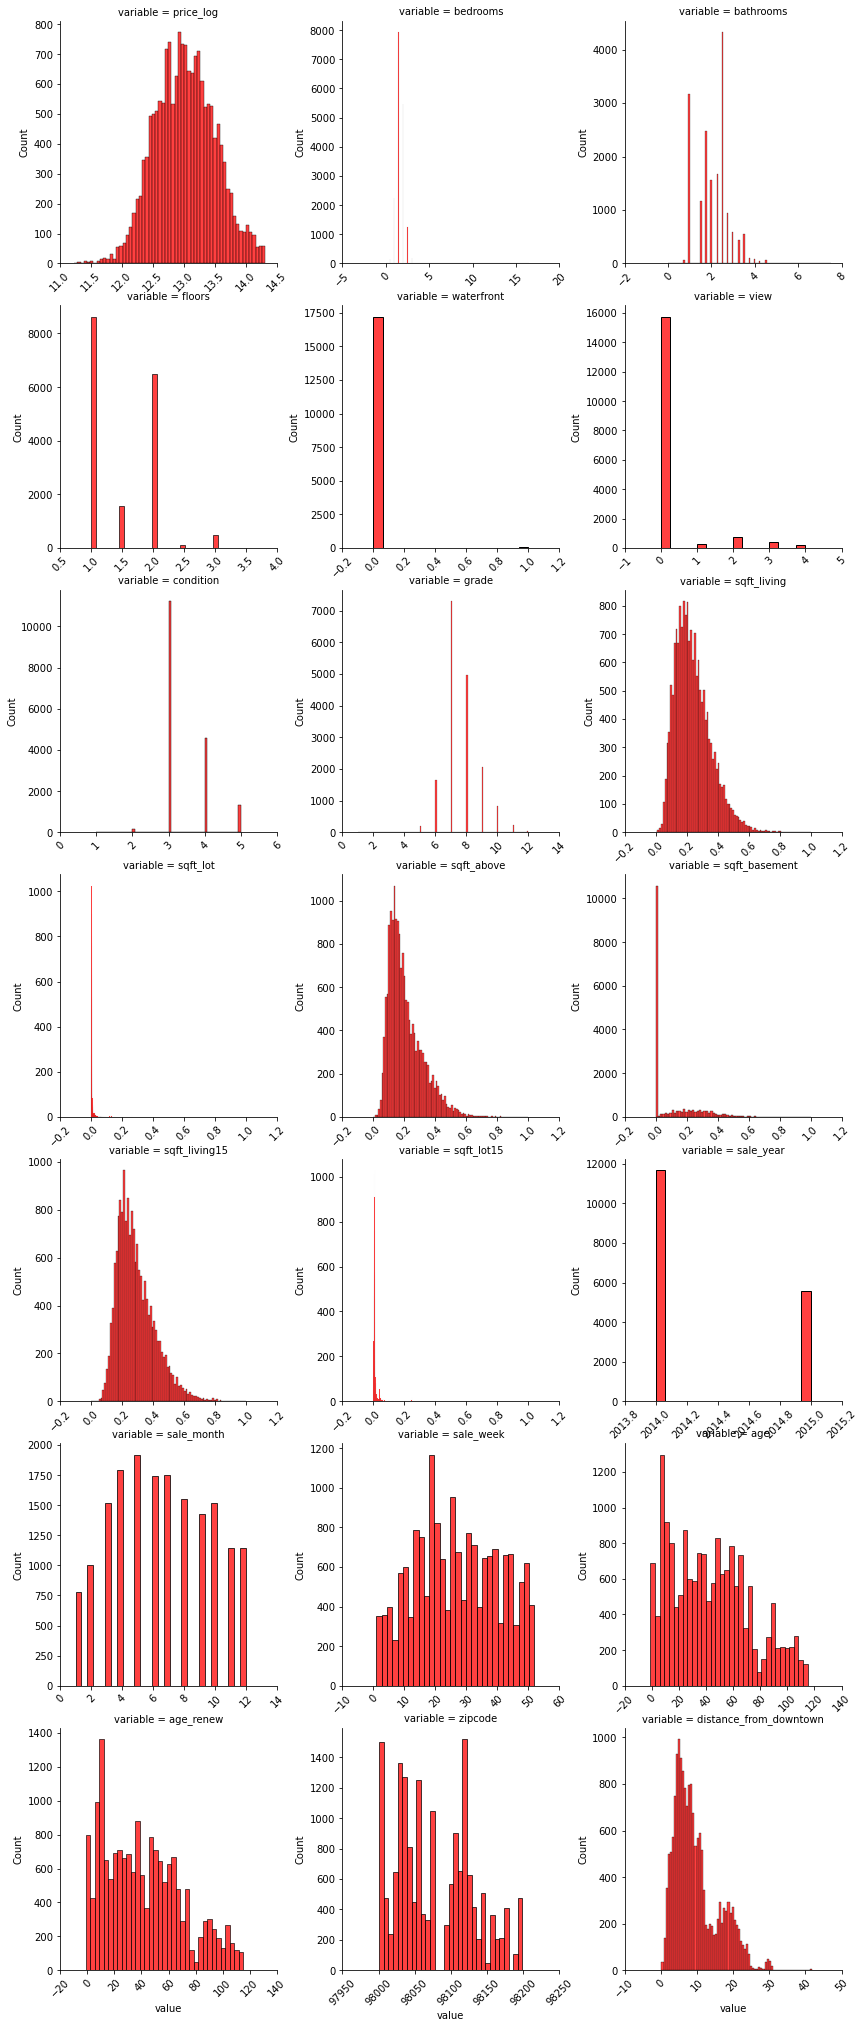

In [22]:
# Plot the histogram of all variables after feature engineering
features = ['price_log', 'bedrooms', 'bathrooms','floors', 'waterfront', 'view', 'condition', 'grade',
            'sqft_living', 'sqft_lot','sqft_above','sqft_basement','sqft_living15', 
            'sqft_lot15',
            'sale_year','sale_month', 'sale_week', 'age', 'age_renew',
            'zipcode', 'distance_from_downtown']

feature_frame = pd.melt(home_sales, value_vars = features)
dis_plot = sns.FacetGrid(feature_frame, col = 'variable', col_wrap = 3, sharex = False, sharey = False, height=4)
dis_plot = dis_plot.map(sns.histplot, 'value', color='r')
dis_plot.set_xticklabels(rotation = 45)
plt.show()

### 3.2 Price distribution among features

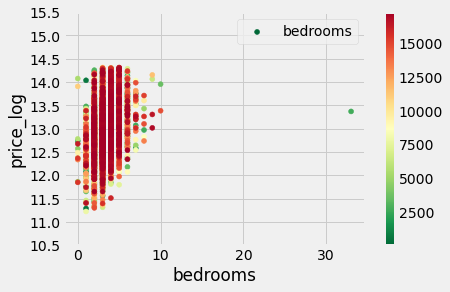

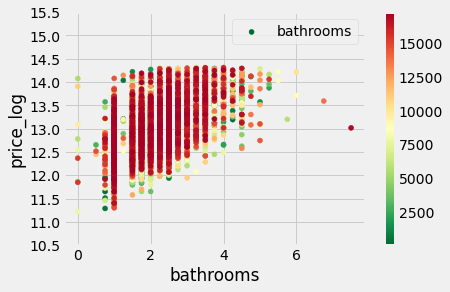

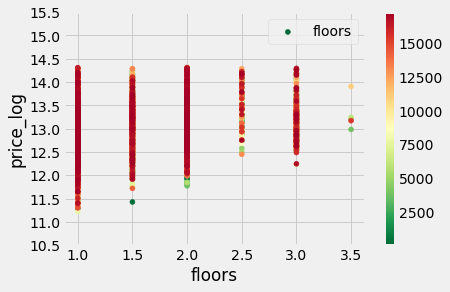

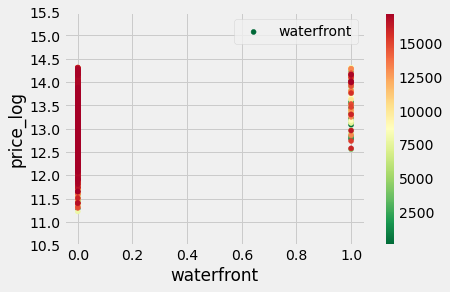

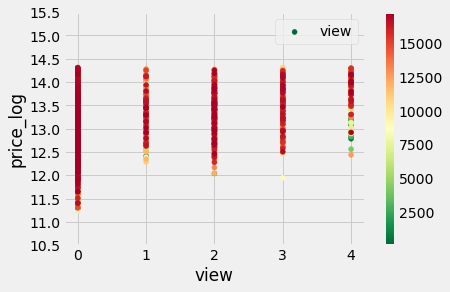

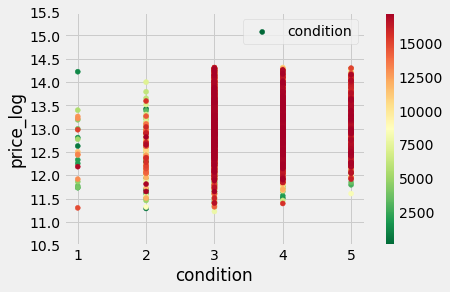

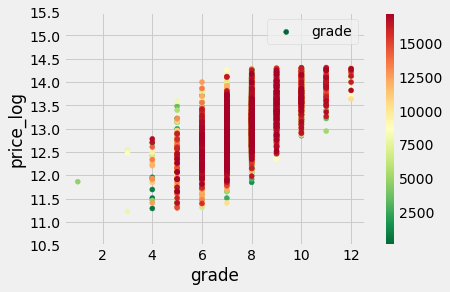

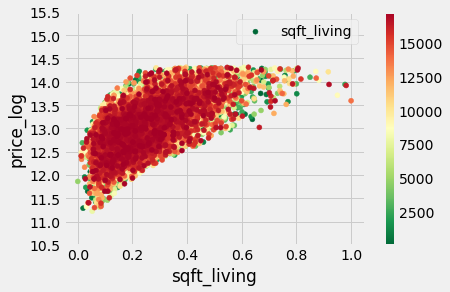

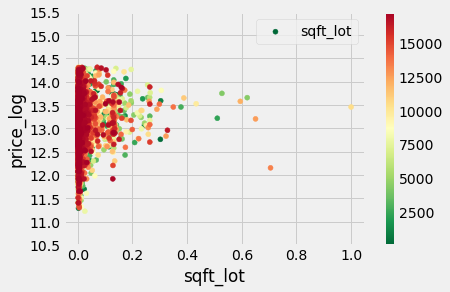

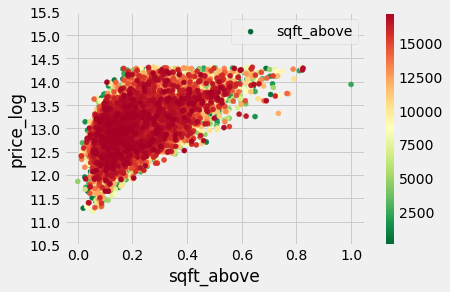

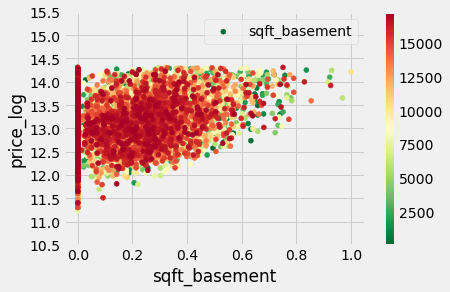

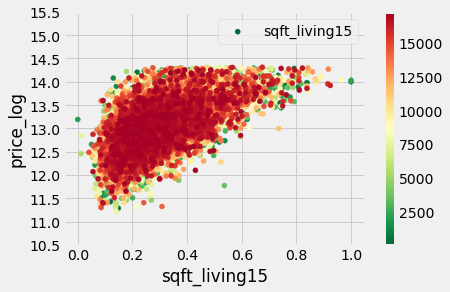

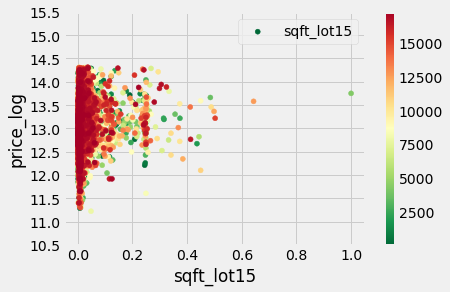

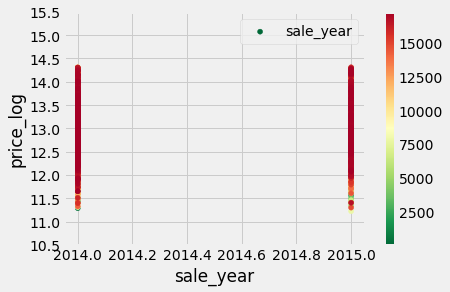

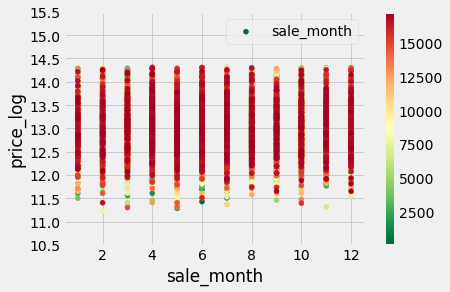

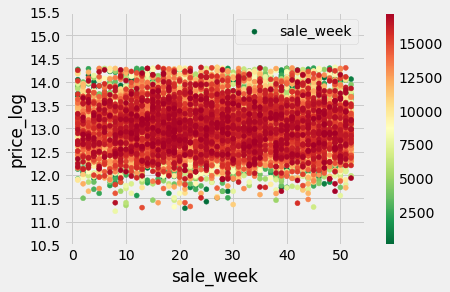

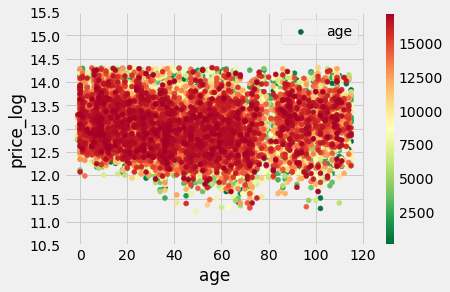

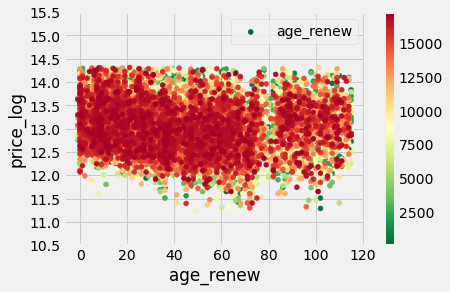

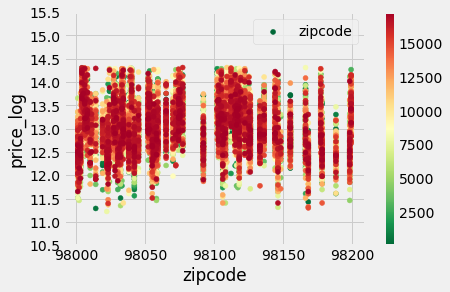

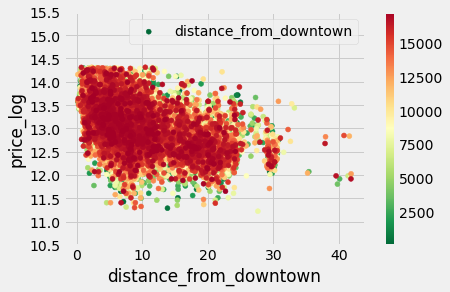

In [23]:
style.use('fivethirtyeight')
cm = plt.cm.get_cmap('RdYlGn_r')
xy = range(1, 17286)
z = xy
for feature in home_sales[features[1:]]:
    scatter_plot = plt.scatter(home_sales[feature], home_sales['price_log'], label = feature, c = z, marker = 'o', s = 25, cmap = cm)
    plt.colorbar(scatter_plot)
    plt.xlabel('' + feature)
    plt.ylabel('price_log')
    plt.yticks([10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 
                14.5, 15.0, 15.5],
               [10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 
                14.5, 15.0, 15.5])
    plt.legend()
    plt.show()

### 3.3 Correlation matrix

Correlation matrix can be useful to get a general idea about the relationship between house price and the correaponding features, as well as the correlation between features themselves.

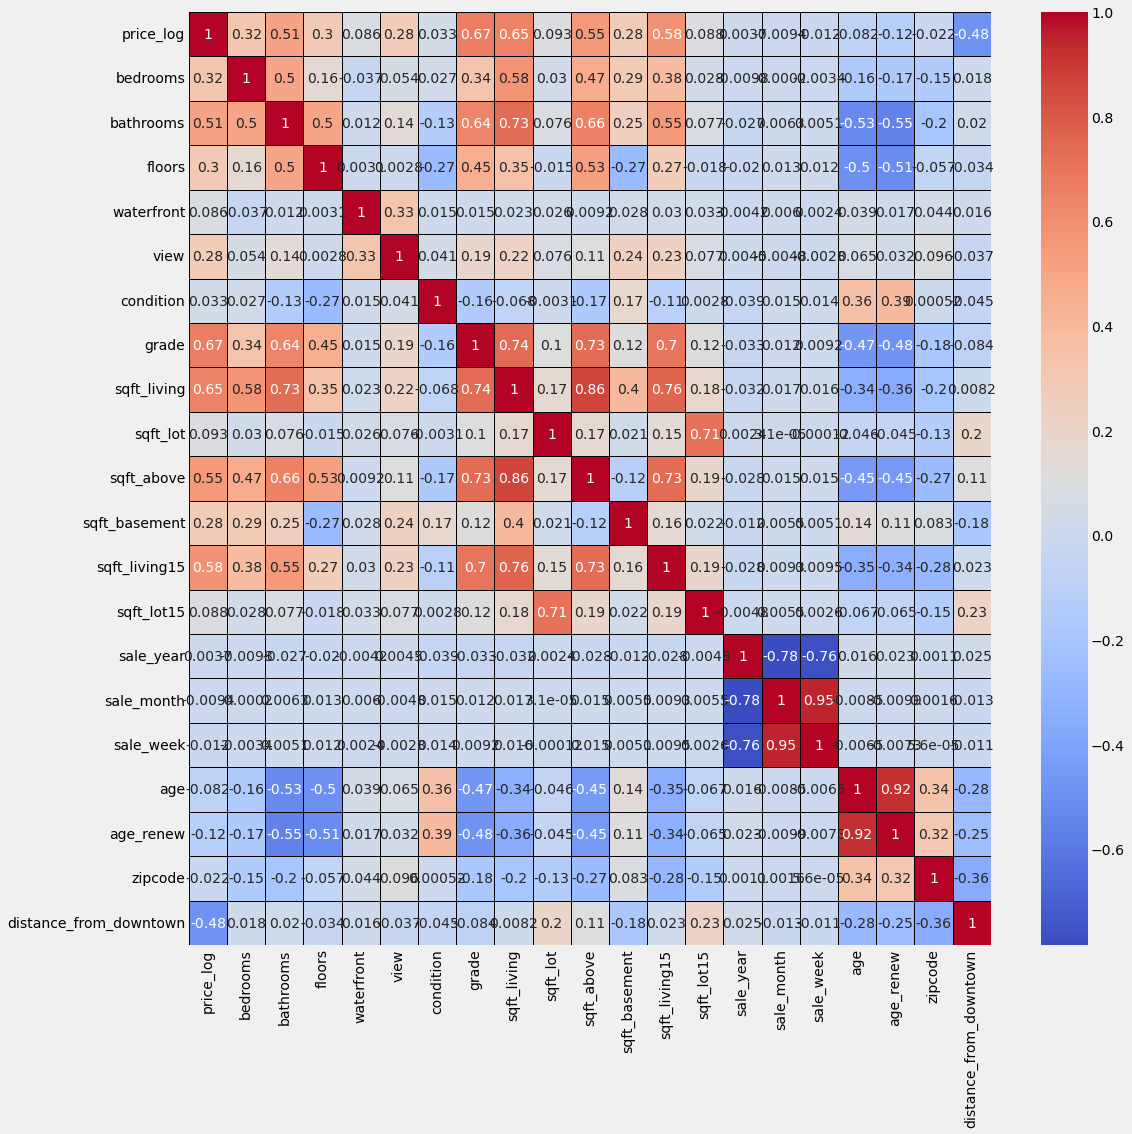

In [24]:
corr_matrix = home_sales[features].corr()
plt.figure(figsize = (16, 16))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', linecolor = 'black', 
            linewidths = 1.0, xticklabels = True, yticklabels = True)
plt.show()

# 4. Feature Selection and Model Fitting

In [25]:
#create dummy variables for 70 zipcodes
home_sales = pd.get_dummies(home_sales, columns = ['zipcode', 'sale_year','sale_month', 
                                                   'sale_week'], drop_first = True)

full_features = home_sales.columns[1:]
train_X = home_sales[full_features]
train_y = home_sales['price_log']

In [26]:
full_features

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       ...
       'sale_week_43', 'sale_week_44', 'sale_week_45', 'sale_week_46',
       'sale_week_47', 'sale_week_48', 'sale_week_49', 'sale_week_50',
       'sale_week_51', 'sale_week_52'],
      dtype='object', length=148)

### 4.1 Forward Selection

In [27]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)
best_model_forward, best_variables_forward = forward_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_variables_forward)

Variables: bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, sqft_living15, sqft_lot15, age, age_renew, distance_from_downtown, zipcode_98002, zipcode_98003, zipcode_98004, zipcode_98005, zipcode_98006, zipcode_98007, zipcode_98008, zipcode_98010, zipcode_98011, zipcode_98014, zipcode_98019, zipcode_98022, zipcode_98023, zipcode_98024, zipcode_98027, zipcode_98028, zipcode_98029, zipcode_98030, zipcode_98031, zipcode_98032, zipcode_98033, zipcode_98034, zipcode_98038, zipcode_98039, zipcode_98040, zipcode_98042, zipcode_98045, zipcode_98052, zipcode_98053, zipcode_98055, zipcode_98056, zipcode_98058, zipcode_98059, zipcode_98065, zipcode_98070, zipcode_98072, zipcode_98074, zipcode_98075, zipcode_98077, zipcode_98092, zipcode_98102, zipcode_98103, zipcode_98105, zipcode_98106, zipcode_98107, zipcode_98108, zipcode_98109, zipcode_98112, zipcode_98115, zipcode_98116, zipcode_98117, zipcode_98118, zipcode_98119, zipcode_9812

In [28]:
len(best_variables_forward)

98

### 4.2 Backward Selection

In [30]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)


allVariables = train_X.columns
best_model_backward, best_variables_backward = backward_elimination(allVariables, train_model, score_model, verbose=True)
print(best_variables_backward)

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age', 'age_renew', 'distance_from_downtown', 'zipcode_98002', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98107', 'zipcode_98109', 'zipcode_98112', 'zipcode_98115', 'zipcode_98116', 

### 4.3 Stepwise Selection

In [31]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model_stepwise, best_variables_stepwise = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_variables_stepwise)

Variables: bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, sqft_living15, sqft_lot15, age, age_renew, distance_from_downtown, zipcode_98002, zipcode_98003, zipcode_98004, zipcode_98005, zipcode_98006, zipcode_98007, zipcode_98008, zipcode_98010, zipcode_98011, zipcode_98014, zipcode_98019, zipcode_98022, zipcode_98023, zipcode_98024, zipcode_98027, zipcode_98028, zipcode_98029, zipcode_98030, zipcode_98031, zipcode_98032, zipcode_98033, zipcode_98034, zipcode_98038, zipcode_98039, zipcode_98040, zipcode_98042, zipcode_98045, zipcode_98052, zipcode_98053, zipcode_98055, zipcode_98056, zipcode_98058, zipcode_98059, zipcode_98065, zipcode_98070, zipcode_98072, zipcode_98074, zipcode_98075, zipcode_98077, zipcode_98092, zipcode_98102, zipcode_98103, zipcode_98105, zipcode_98106, zipcode_98107, zipcode_98108, zipcode_98109, zipcode_98112, zipcode_98115, zipcode_98116, zipcode_98117, zipcode_98118, zipcode_98119, zipcode_9812

In [32]:
len(best_variables_stepwise)

93

In [33]:
# compare the feature selection results of different methods
print('stepwise not forward', set(best_variables_stepwise) - set(best_variables_forward), '\n')
print('forward not stepwise', set(best_variables_forward) - set(best_variables_stepwise), '\n')
print('stepwise not backward', set(best_variables_stepwise) - set(best_variables_backward), '\n')
print('backward not stepwise', set(best_variables_backward) - set(best_variables_stepwise), '\n')
print('forward not backward', set(best_variables_forward) - set(best_variables_backward), '\n')
print('backward not forward', set(best_variables_backward) - set(best_variables_forward), '\n')

stepwise not forward set() 

forward not stepwise {'zipcode_98108', 'zipcode_98146', 'zipcode_98106', 'sale_month_4', 'zipcode_98003'} 

stepwise not backward {'sale_month_6', 'sale_month_2', 'sale_week_3', 'sale_month_3', 'sale_week_4', 'sqft_above'} 

backward not stepwise {'sale_week_49', 'sale_week_46', 'sale_week_19', 'sqft_basement', 'sale_week_48', 'sale_week_22', 'sale_week_43', 'sale_week_25', 'sale_month_12', 'sale_week_23', 'sale_week_47', 'sale_week_41', 'sale_week_42', 'sale_week_44', 'sale_week_33', 'sale_week_24', 'sale_week_39', 'sale_week_11', 'sale_week_18', 'sale_week_45', 'sale_week_27', 'sale_week_9', 'sale_week_34', 'sale_week_32', 'sale_week_13', 'sale_week_38', 'sale_week_20', 'sale_week_31', 'sale_week_28', 'sale_week_30', 'sale_week_37', 'sale_week_36', 'sale_week_29', 'sale_week_35', 'sale_week_17', 'sale_week_40', 'sale_week_10', 'sale_week_16'} 

forward not backward {'sale_month_6', 'zipcode_98108', 'sale_month_2', 'sale_week_3', 'zipcode_98146', 'zipcode_

##### From the comparison above we notice that the selection result between forward and stepwise are very similar. The difference between backword and the other two methods mainly concentrates on the week, month and zipcodes.
#####  For those important features including grade, distance_from_downtown, sqft_living and view, all of the three methods provide a similar result.
##### Therefore, we decide to use the features selected by forward for the next model fitting part.

### 4.4 K-fold Cross Validation 

We use RMSE in this project as a the Accuracy Metric 

In [34]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [35]:
home_sales.columns

Index(['price_log', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade',
       ...
       'sale_week_43', 'sale_week_44', 'sale_week_45', 'sale_week_46',
       'sale_week_47', 'sale_week_48', 'sale_week_49', 'sale_week_50',
       'sale_week_51', 'sale_week_52'],
      dtype='object', length=149)

In [36]:
def Cross_train_test_score(model, feature):
  
  X = home_sales.iloc[:, 1:][feature].to_numpy()
  Y = home_sales.iloc[:,0].to_numpy()

  acc_score_train = []
  acc_score_test = []

  for train_index, test_index in kf.split(X):
    x_trn, x_tst = X[train_index], X[test_index]
    y_trn, y_tst = Y[train_index], Y[test_index]
    
    model.fit(x_trn,y_trn)
    
    pred_train = model.predict(x_trn)
    pred_test = model.predict(x_tst)

    acc_train = round(np.sqrt(mean_squared_error(pred_train, y_trn)), 5)
    acc_score_train.append(acc_train)

    acc_test = round(np.sqrt(mean_squared_error(pred_test, y_tst)), 5)
    acc_score_test.append(acc_test)

  avg_acc_score_train = round(sum(acc_score_train)/5, 5)
  avg_acc_score_test = round(sum(acc_score_test)/5, 5)
  
  print('Train RMSE of each fold:', acc_score_train)
  print('Avg train RMSE : {}'.format(avg_acc_score_train))
    

  print('Test RMSE of each fold:',acc_score_test)
  print('Avg test RMSE : {}'.format(avg_acc_score_test))  

#### 4.4.1 Linear regression

In [37]:
lrg_model = LinearRegression()
feature = best_variables_forward

Cross_train_test_score(lrg_model, best_variables_forward)

Train RMSE of each fold: [0.17765, 0.17837, 0.1764, 0.17763, 0.17796]
Avg train RMSE : 0.1776
Test RMSE of each fold: [0.17912, 0.17618, 0.18404, 0.1794, 0.17777]
Avg test RMSE : 0.1793


#### 4.4.2 Regression Tree

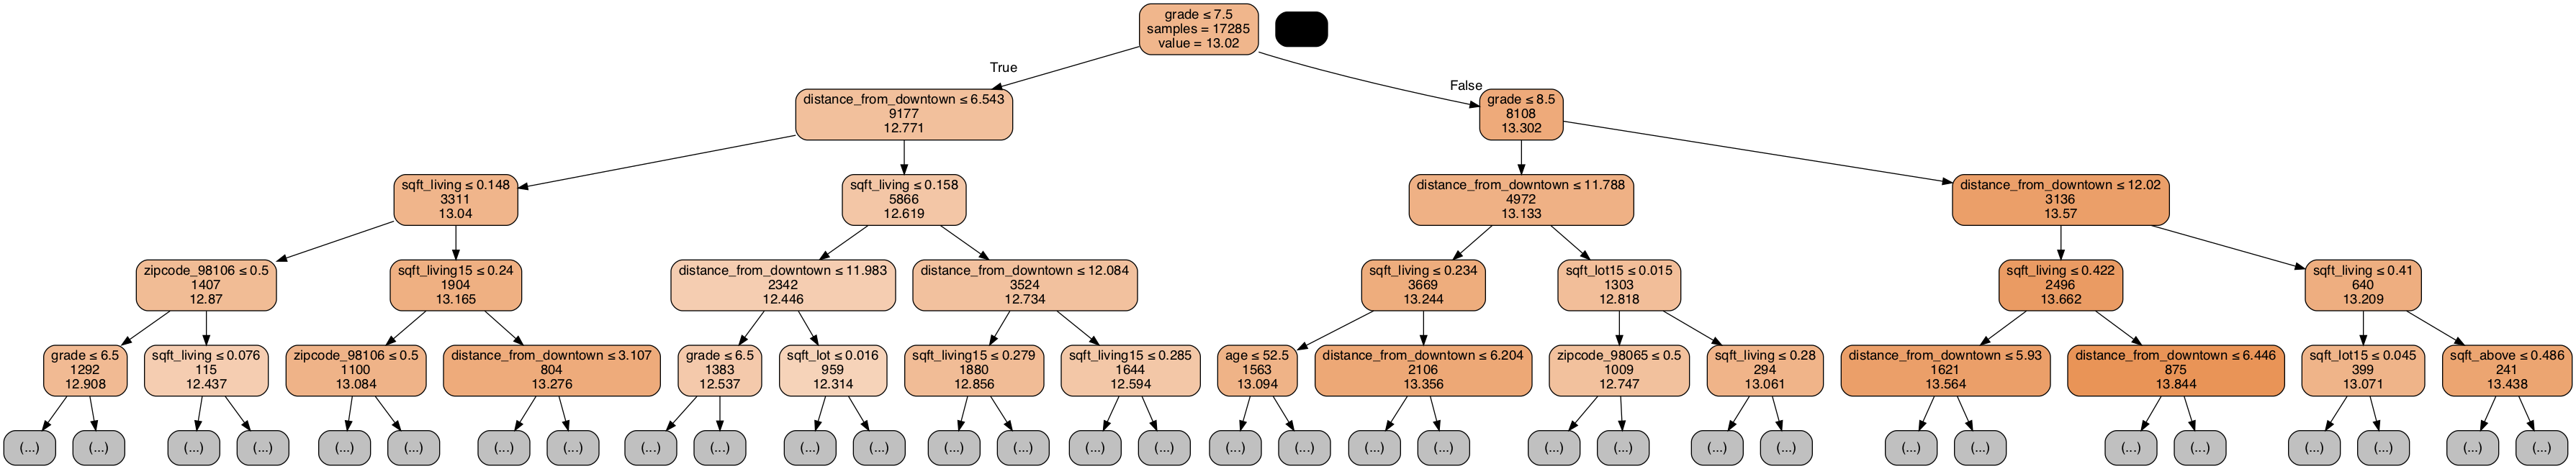

In [38]:
# use the fullClassTree

# use the fullClassTree
X = home_sales.iloc[:, 1:]
Y = home_sales.iloc[:,0]

fullClassTree = DecisionTreeRegressor(criterion='mse',random_state=1, max_depth = None)
fullClassTree.fit(X[best_variables_forward], Y)
plotDecisionTree(fullClassTree, feature_names= best_variables_forward, max_depth=4)

In [39]:
Cross_train_test_score(fullClassTree, feature)

Train RMSE of each fold: [0.00819, 0.00545, 0.0092, 0.0067, 0.00942]
Avg train RMSE : 0.00779
Test RMSE of each fold: [0.26145, 0.25536, 0.26147, 0.26528, 0.25237]
Avg test RMSE : 0.25919


##### The model performance of full tree shows a significant feature of overfitting, which means it fits the training dataset well, but with high variance in test set.

In [40]:
param_grid = {
    'max_depth': [39, 41, 43, 45, 47], 
    'min_impurity_decrease': [0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005], 
    'min_samples_split': [70, 75, 80, 85, 90]
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X[best_variables_forward], Y)
print('the bset parameters: ', gridSearch.best_params_)

the bset parameters:  {'max_depth': 39, 'min_impurity_decrease': 0, 'min_samples_split': 70}


In [1]:
param_grid = {
    'max_depth': [39, 41, 43, 45, 47], 
    'min_impurity_decrease': [0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005], 
    'min_samples_split': [66, 68, 70, 72, 74]
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X[best_variables_forward], Y)
print('Improved parameters: ', gridSearch.best_params_)

NameError: name 'GridSearchCV' is not defined

In [ ]:
feature = best_variables_forward

regTree = gridSearch.best_estimator_

Cross_train_test_score(regTree, feature)

#### 4.4.3 Random Forest

In [ ]:
rf_reg = RandomForestRegressor()
predictor = best_variables_forward

rf_model = rf_reg.fit(X, Y)
y_pred_rf = rf_model.predict(X)

rf_params = {'n_estimators':[10,20],'max_depth':[8,10],'max_leaf_nodes':[70,90]}
rf_grid = GridSearchCV(rf_reg,rf_params,cv = 5)
rf_model_two = rf_grid.fit(X,Y)
y_pred_rf_two = rf_model_two.predict(X)

In [ ]:
rf_model_two.best_params_

In [ ]:
rf_params = {'n_estimators':[20],'max_depth':[10],'max_leaf_nodes':[90]}
rf_grid = GridSearchCV(rf_reg,rf_params,cv = 5)
rf_model_three = rf_grid.fit(X,Y)

Cross_train_test_score(rf_grid, feature)

##### After comparing the accuracy matric, we found that the Linear regression is the most robust and accuracy one.
##### Therefore, we finally decide to use linear regression to make the prediction in test set.

# 5. Results, findings

### 5.1 Data processing of test dataset

In [ ]:
home_sales_test = pd.read_csv('test_dataset.csv')

In [ ]:
home_sales_test.head()

In [ ]:
home_sales_test.shape

In [ ]:
home_sales_test.describe()

In [ ]:
# 1) change data type of date, create sale_year, sale_month and sale_week
home_sales_test['sale_date'] = [x[:8] for x in home_sales_test.date]
home_sales_test.sale_date = home_sales_test.sale_date.apply(lambda x: datetime.strptime(x, '%Y%m%d'))
home_sales_test.drop(columns = 'date', inplace = True)
home_sales_test.drop(columns = 'id', inplace = True)
home_sales_test['sale_year'] = home_sales_test['sale_date'].dt.year
home_sales_test['sale_month'] = home_sales_test['sale_date'].dt.month
home_sales_test['sale_week'] = home_sales_test['sale_date'].dt.week


# 2) create house age variables
home_sales_test['age'] = pd.DatetimeIndex(home_sales_test['sale_date']).year - home_sales_test['yr_built']
home_sales_test['age_renew'] = np.where(home_sales_test.yr_renovated == 0,
                home_sales_test.age, 
                pd.DatetimeIndex(home_sales_test['sale_date']).year - home_sales_test.yr_renovated)

# 3) Normalize variables related to sqft
scaler = preprocessing.MinMaxScaler()
sqft_names = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
                            'sqft_living15', 'sqft_lot15']
home_sales_test[sqft_names] = scaler.fit_transform(home_sales_test[sqft_names])

# 4) create variable of distance to downtown
home_sales_test['lat_long'] = tuple(zip(home_sales_test.lat,home_sales_test.long))

seattle_latlong = [47.608013,-122.335167]
seattle_list_test = []
for i in home_sales_test['lat_long']:
    seattle_list_test.append(haversine((seattle_latlong),(i),unit = 'mi'))

home_sales_test['distance_from_seattle'] = seattle_list_test

bellevue = tuple([47.610378, -122.200676])
bell_distances_test = []
for i in home_sales_test['lat_long']:
    bell_distances_test.append(haversine((bellevue),(i),unit = 'mi'))
bell_distances_test[:5]

home_sales_test['distance_from_bellevue'] = bell_distances_test

home_sales_test['distance_from_downtown'] = home_sales_test[['distance_from_bellevue', 'distance_from_seattle']].min(axis=1)

home_sales_test.drop(columns=['lat','long', 'lat_long', 'distance_from_bellevue','distance_from_seattle' ], inplace = True)

# 5) generate dummies for zipcode', 'sale_year','sale_month' and 'sale_week'

home_sales_test = pd.get_dummies(home_sales_test, columns = ['zipcode', 'sale_year','sale_month', 
                                                   'sale_week'], drop_first =  True)
# 6) drop redundant variables:
home_sales_test = home_sales_test.drop(['sale_date', 'yr_built','yr_renovated'], axis = 1)

In [ ]:
# Check if features in test dataset after frocessing is consistent with the model fitting part:
home_sales_test.columns == full_features

In [ ]:
#Final Model
home_sales_test['price_log'] = lrg_model.predict(home_sales_test[best_variables_forward])

#transforming back from log price
home_sales_test['predict_price'] = np.exp(home_sales_test['price_log'])

In [ ]:
# from google.colab import drive
# drive.mount('drive')

In [ ]:
# from google.colab import files
# home_sales_test.to_csv('final_test_with_price.csv') 
# files.download('final_test_with_price.csv')